In [11]:
import pandas as pd
import matplotlib as plt

%matplotlib inline

## Data Cleaning and reformat

In [3]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [17]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
data = data.set_index("timestamp")

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [22]:
data.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=True)

In [35]:
data.to_csv('data/cleaned_data')

<AxesSubplot:xlabel='timestamp'>

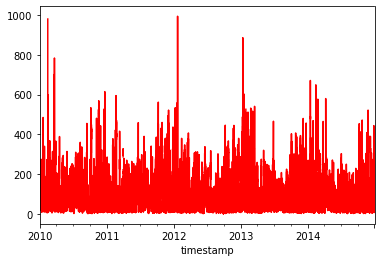

In [34]:
data['pm2.5'].plot(kind='line',color='red')